### Imports

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import json

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Classes

In [2]:
#Class: RNN
class RNN(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        #h0 = self.initHidden()
        h_list, hn = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

In [3]:
#Class : LSTM
class LSTM(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        h_list, (hn,cn) = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

## Setup

In [4]:
#Parameters to get several scenari
TRAINING_NUMBER = 400
USE_NOISY_DATA = False
USE_MIXED_EFFECT = False
RANDOM_TIME = False
MODEL = RNN        
RE = 'Mixed' if USE_MIXED_EFFECT else 'Fixed'
Time = 'random time' if RANDOM_TIME else 'regular time'

In [5]:
CSV_FILE = "../../data/synthetic_bph_1/Simulations " + Time + "/simulation1.csv"
CSV_Dtest = "../../data/synthetic_bph_1/Simulations " + Time + "/01_test.csv"
CSV_RES_R = "../../data/synthetic_bph_1/Résultats " + Time

In [6]:
#data loading
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
dtest = pd.read_csv(CSV_Dtest, sep=";", decimal=",")
predictions_R_test = pd.read_csv(CSV_RES_R + "/Predictions.csv", sep=",", decimal=".")

In [7]:
x_labels = [
    c for c in data.columns if c.startswith("x") and ((("_" in c) is USE_NOISY_DATA and ('obs' in c) is USE_NOISY_DATA))
]
if 'x8' not in x_labels:
    x_labels.append('x8')
#assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c))
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_fixed_obs']


In [8]:
predictions_R_train = data[['individus','temps', 'pred_mixed', 'pred_fixed', 'pred_naif_fixed']] #don't forget to add , 'pred_naif_mixed'
predictions_R_test = predictions_R_test[['individus','temps', 'pred_mixed_1', 'pred_fixed_1', 'pred_naif_fixed_1']] #don't forget to add , 'pred_naif_mixed _1'

## Preprocessing

In [9]:
data_norm = data.copy()
data_norm = data_norm.dropna()
N_train = random.sample(range(1,501), TRAINING_NUMBER)
N_train.sort()
N_val =  [x for x in range(1,501) if x not in N_train]
data_train = data_norm.loc[data_norm['individus'].isin(N_train)]
data_val = data_norm[~data_norm['individus'].isin(N_train)]

scaler_x = RobustScaler()
data_train.loc[:,x_labels] = scaler_x.fit_transform(data_train[x_labels])
data_val.loc[:,x_labels] = scaler_x.transform(data_val[x_labels ])

scaler_y = RobustScaler()
data_train.loc[:,y_labels] = scaler_y.fit_transform(data_train[y_labels])
data_val.loc[:,y_labels] = scaler_y.transform(data_val[y_labels])

groupby = data_train.groupby('individus')[x_labels].apply(np.array)
input_train = [torch.Tensor(x) for x in groupby]
input_train = torch.stack(input_train)
groupby = data_train.groupby('individus')[y_labels].apply(np.array)
target_train = [torch.Tensor(x) for x in groupby]
target_train = torch.stack(target_train)

groupby = data_val.groupby('individus')[x_labels].apply(np.array)
input_val = [torch.Tensor(x) for x in groupby]
input_val = torch.stack(input_val)
groupby = data_val.groupby('individus')[y_labels].apply(np.array)
target_val = [torch.Tensor(x) for x in groupby]
target_val = torch.stack(target_val)


In [10]:
dtest_norm = dtest.copy()
dtest_norm = dtest_norm.dropna()

scaler_x_test = RobustScaler()
dtest_norm.loc[:,x_labels] = scaler_x.fit_transform(dtest_norm[x_labels])

scaler_y_test = RobustScaler()
dtest_norm.loc[:,y_labels] = scaler_y.fit_transform(dtest_norm[y_labels])

groupby = dtest_norm.groupby('individus')[x_labels].apply(np.array)
input_test = [torch.Tensor(x) for x in groupby]
input_test = torch.stack(input_test)
groupby = dtest_norm.groupby('individus')[y_labels].apply(np.array)
target_test = [torch.Tensor(x) for x in groupby]
target_test = torch.stack(target_test)

## Training

In [11]:
#hyperparamètres
hidden_size = [25]
learning_rate = [0.001]
criterion = torch.nn.MSELoss()
epoch = 20000
eps = 0.0005

In [12]:
#Training with convergence criteria and GridSearch with RNN
min_loss = float('inf')
for h in hidden_size:
    for lr in learning_rate:
        model = MODEL(input_size = 8, hidden_size=h, output_size=1, num_layers=2)
        optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
        loss_val = [float('inf')]*100
        loss_train = []
        cur_loss_val = 0
        nb_epochs = 0
        while abs(np.max(loss_val[-100:] - np.min(loss_val[-100:] + [cur_loss_val]))) >= eps and nb_epochs < epoch:

            y_val = model(input = input_val)
            cur_loss_val = criterion(y_val, target_val).item()
            loss_val.append(cur_loss_val)

            optimizer.zero_grad()
            y_pred = model(input=input_train)
            loss = criterion(y_pred, target_train)
            loss.backward()
            optimizer.step()

            cur_loss_train = loss.item()
            loss_train.append(cur_loss_train)
            
            nb_epochs += 1
        if cur_loss_val < min_loss:
            min_loss = cur_loss_val
            res = (h, lr)

loss_val = loss_val[101:]
print(h, lr)
print(nb_epochs)

25 0.001
2042


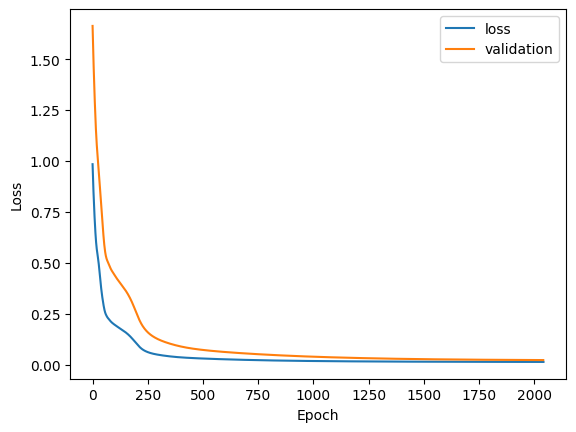

In [13]:
#plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_train, label ="loss")
plt.plot(loss_val, label = "validation")
plt.legend()
plt.show()

In [14]:
#unscale data and aggregate training set
multi_index = pd.MultiIndex.from_product([N_train, range(y_pred.shape[1])], names=['individus', 'temps'])
df = pd.DataFrame(index = multi_index, data = y_pred.detach().numpy().flatten(), columns=['y_pred_' + MODEL.__name__ + '_' + RE])
df = df.reset_index()
df = df.set_index(data_train.index)
df.loc[:,'y_pred_' + MODEL.__name__ + '_' + RE] = scaler_y.inverse_transform(df[['y_pred_' + MODEL.__name__ + '_' + RE]])
data_train.loc[:,y_labels] = scaler_y.inverse_transform(data_train[y_labels])

multi_index = pd.MultiIndex.from_product([N_val, range(y_val.shape[1])], names=['individus', 'temps'])
df_val = pd.DataFrame(index = multi_index, data = y_val.detach().numpy().flatten(), columns=['y_pred_' + MODEL.__name__ + '_' + RE])
df_val = df_val.reset_index()
df_val = df_val.set_index(data_val.index)
df_val.loc[:,'y_pred_' + MODEL.__name__ + '_' + RE] = scaler_y.inverse_transform(df_val[['y_pred_' + MODEL.__name__ + '_' + RE]])
data_val.loc[:,y_labels] = scaler_y.inverse_transform(data_val[y_labels])

df = pd.concat((df,df_val))
data_train = pd.concat((data_train, data_val))

In [15]:
#Results on training
MAE_list_train = []
MSE_list_train = []
MAE_list_train_obs = []
MSE_list_train_obs = []
for k in range(1,501):
    pred_k = df[(df['temps']>5) & (df['individus'] == k)]['y_pred_' + MODEL.__name__ + '_' + RE]
    target_k = data_train[(data_train['temps']>5) & (data_train['individus'] == k)][y_labels[0][:-4]]
    target_k_obs = data_train[(data_train['temps']>5) & (data_train['individus'] == k)][y_labels]
    MAE_list_train.append(MAE(pred_k, target_k))
    MSE_list_train.append(MSE(pred_k, target_k))
    MAE_list_train_obs.append(MAE(pred_k, target_k_obs))
    MSE_list_train_obs.append(MSE(pred_k, target_k_obs))
print("mean MAE on train data: ", np.mean(MAE_list_train))
print("mean MSE on train data: ", np.mean(MSE_list_train))
print("mean MAE on noised train data: ", np.mean(MAE_list_train_obs))
print("mean MSE on noised train data: ", np.mean(MSE_list_train_obs))

mean MAE on train data:  0.3088396453311326
mean MSE on train data:  0.3238853045596206
mean MAE on noised train data:  0.8775605569797238
mean MSE on noised train data:  1.3220428690203867


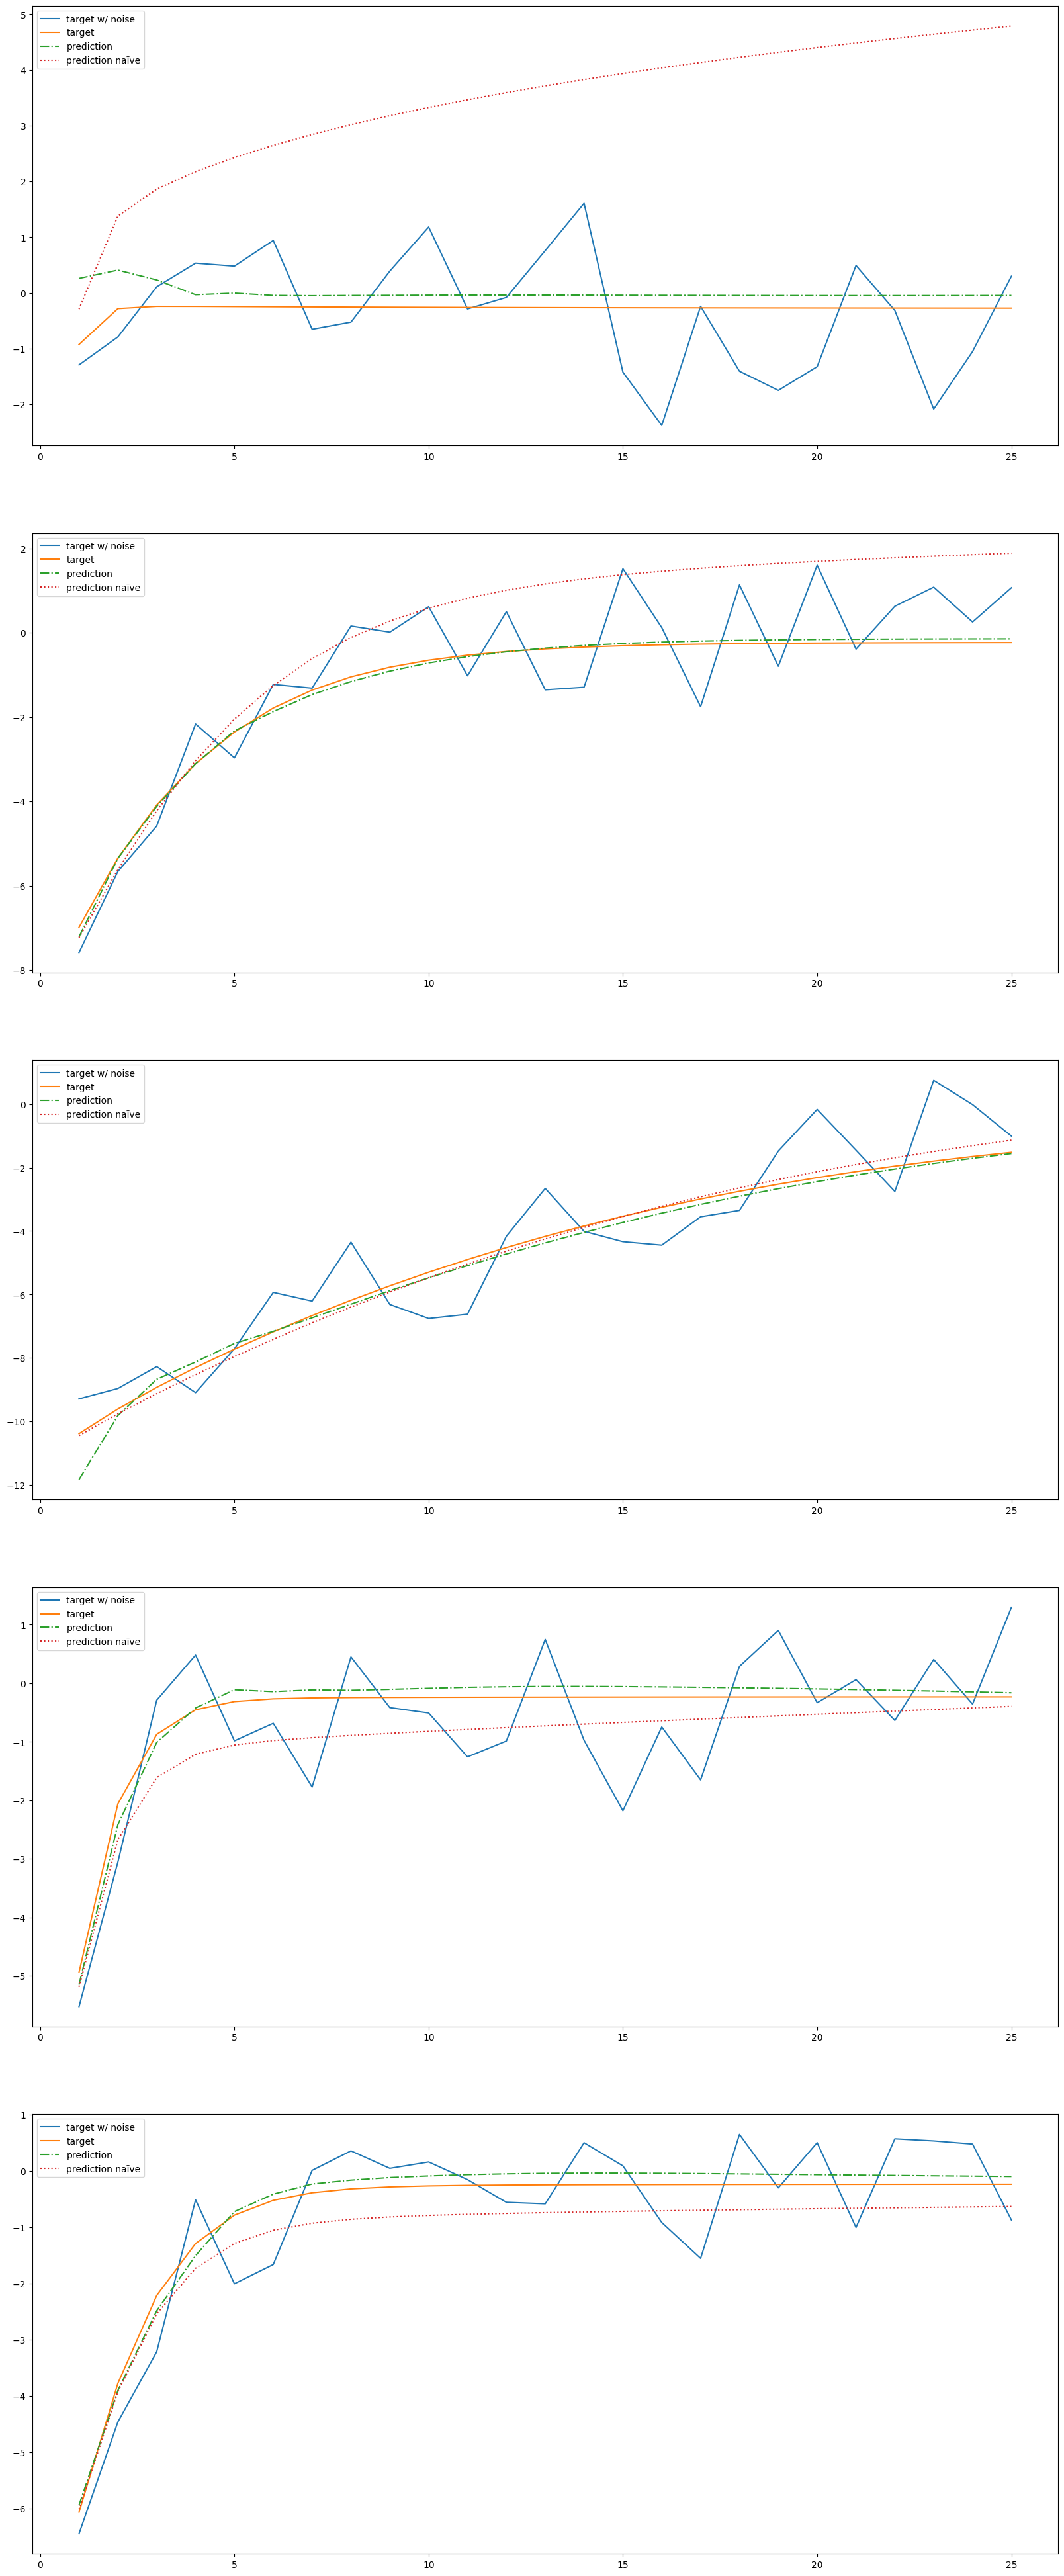

In [16]:
#Plot 4 random curves from training data and worst individual
n = 5
ex = np.random.choice(N_train, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])]['temps'],
                data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])][y_labels], 
                label= 'target w/ noise')
    axs[k].plot(data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])]['temps'],
                data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])][y_labels[0][:-4]], 
                label= 'target')
    axs[k].plot(df[(data_train['temps']!=0) & (df['individus']== ex[k])]['temps'],
                df[(df['temps']!=0) & (df['individus']==ex[k])]['y_pred_' + MODEL.__name__ + '_' + RE], 
                label= 'prediction', linestyle='dashdot')
    axs[k].plot(predictions_R_train[(predictions_R_train['temps']!=0) & (predictions_R_train['individus']== ex[k])]['temps'],
                predictions_R_train[(predictions_R_train['temps']!=0) & (predictions_R_train['individus']== ex[k])]['pred_naif_fixed'], 
                label= 'prediction naïve', linestyle='dotted')
    axs[k].legend()
plt.savefig("../../models/ODE-RNN/Résultats/Graphs/TRAIN_" + MODEL.__name__ + "_" + RE + Time + ".png")

## Test

In [17]:
y_test = model(input_test)
multi_index_test = pd.MultiIndex.from_product([range(y_test.shape[0]), range(y_test.shape[1])], names=['individus', 'temps'])
df_test = pd.DataFrame(index = multi_index_test, data = y_test.detach().numpy().flatten(), columns=['y_test_' + MODEL.__name__ + '_' + RE])
df_test = df_test.reset_index()
df_test = df_test.set_index(dtest_norm.index)
df_test['individus']+=1
df_test.loc[:,'y_test_' + MODEL.__name__ + '_' + RE] = scaler_y.inverse_transform(df_test[['y_test_' + MODEL.__name__ + '_' + RE]])
dtest_norm.loc[:,y_labels] = scaler_y.inverse_transform(dtest_norm[y_labels])

In [18]:
#Scores on test data
MAE_list_test = []
MSE_list_test = []
MAE_list_test_obs = []
MSE_list_test_obs = []
for k in range(1,501):
    pred_k = df_test[(df_test['temps']>5) & (df_test['individus'] == k)]['y_test_' + MODEL.__name__ + '_' + RE]
    target_k = dtest_norm[(dtest_norm['temps']>5) & (dtest_norm['individus'] == k)][y_labels[0][:-4]]
    target_k_obs = dtest_norm[(dtest_norm['temps']>5) & (dtest_norm['individus'] == k)][y_labels]
    MAE_list_test.append(MAE(pred_k,target_k))
    MSE_list_test.append(MSE(pred_k,target_k))
    MAE_list_test_obs.append(MAE(pred_k,target_k_obs))
    MSE_list_test_obs.append(MSE(pred_k,target_k_obs))
print("mean MAE on test data: ", np.mean(MAE_list_test))
print("mean MSE on test data: ", np.mean(MSE_list_test))
print("mean MAE on noised test data: ", np.mean(MAE_list_test_obs))
print("mean MSE on noised test data: ", np.mean(MSE_list_test_obs))

mean MAE on test data:  0.2742603770404047
mean MSE on test data:  0.5122038698374026
mean MAE on noised test data:  0.8859512539514308
mean MSE on noised test data:  1.4952241526237624


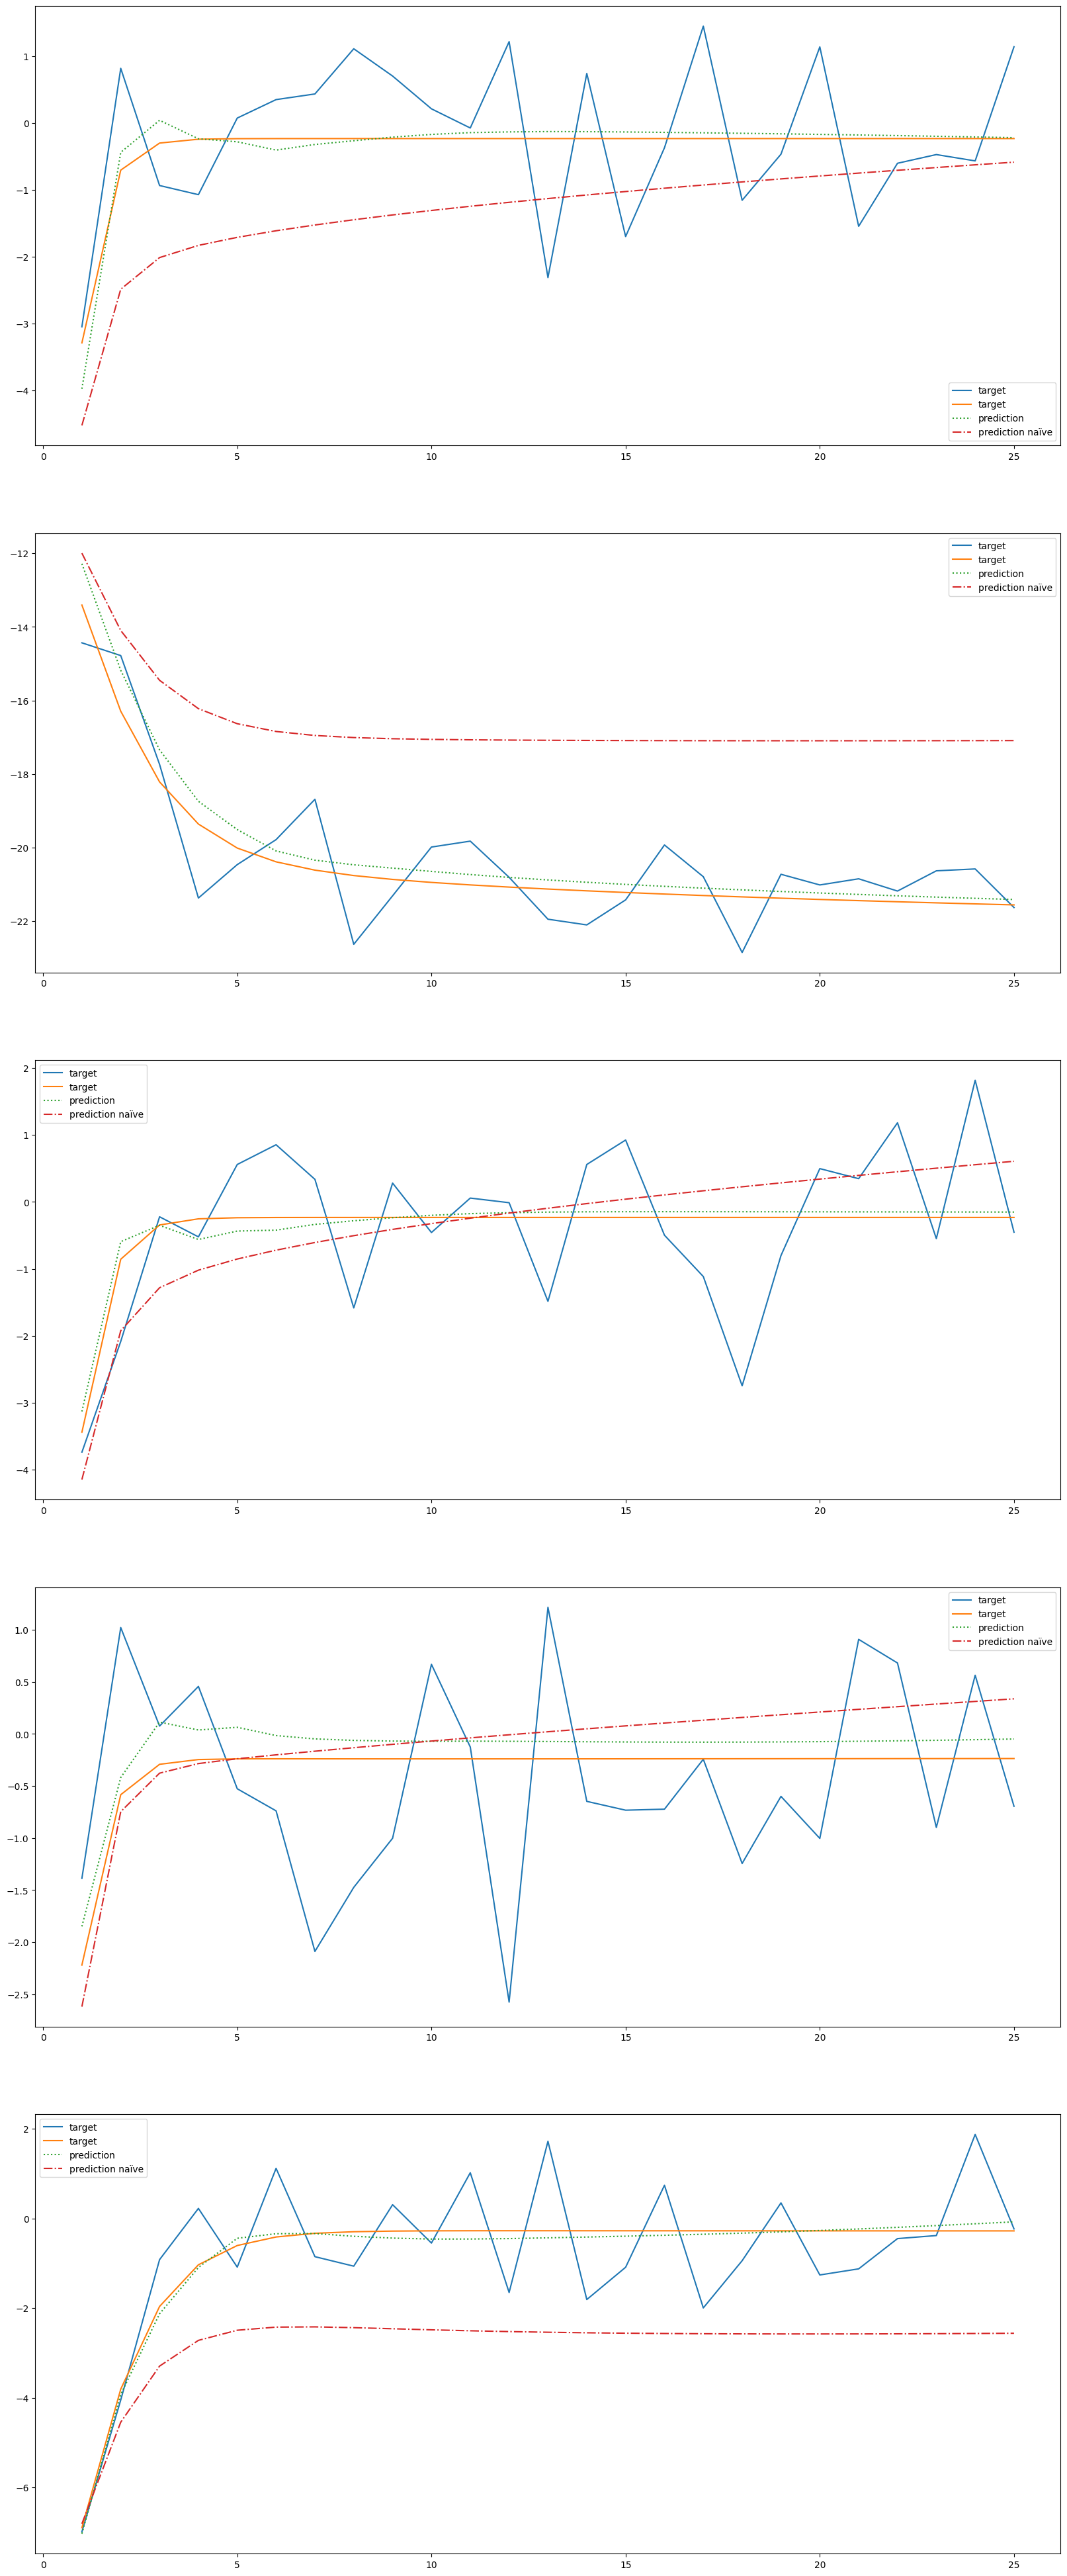

In [21]:
n = 5
ex = randint(1,501, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])]['temps'], 
                dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])][y_labels], 
                label= 'target')
    axs[k].plot(dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])]['temps'], 
                dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])][y_labels[0][:-4]], 
                label= 'target')
    axs[k].plot(df_test.loc[(df_test['temps']!=0) & (df_test['individus']==ex[k])]['temps'],
                df_test.loc[(df_test['temps']!=0) & (df_test['individus']==ex[k])]['y_test_' + MODEL.__name__ + '_' + RE], 
                label= 'prediction', linestyle='dotted')
    axs[k].plot(predictions_R_test[(predictions_R_test['temps']!=0) & (predictions_R_test['individus']== ex[k])]['temps'],
                predictions_R_test[(predictions_R_test['temps']!=0) & (predictions_R_test['individus']== ex[k])]['pred_naif_fixed_1'], 
                label= 'prediction naïve', linestyle='dashdot')
    axs[k].legend()
plt.savefig("../../models/ODE-RNN/Résultats/TEST_" + MODEL.__name__ + RE + Time +".png")

## Saving results

In [20]:
df.to_csv("../../models/ODE-RNN/Résultats/Prédictions_entrainement" + MODEL.__name__ + "_" + RE + Time + ".csv", index=False)
df_test.to_csv("../../models/ODE-RNN/Résultats/Prédictions_test" + MODEL.__name__ + "_" + RE + Time + ".csv", index=False)

In [21]:
results = pd.DataFrame([[RE, MODEL.__name__, nb_epochs, np.mean(MAE_list_train), np.mean(MSE_list_train), np.mean(MAE_list_train_obs), np.mean(MSE_list_train_obs), np.mean(MAE_list_test), np.mean(MSE_list_test), np.mean(MAE_list_test_obs), np.mean(MSE_list_test_obs)]], 
                       columns=['Random effect', 'Model', 'nb_epochs', "MAE moyenne sur l'entrainement", "MSE moyenne sur l'entrainement", "MAE moyenne sur l'entrainement bruité", "MSE moyenne sur l'entrainement bruité", "MAE moyenne sur le test", "MSE moyenne sur le test", "MAE moyenne sur le test bruité", "MSE moyenne sur le test bruité"])
print(results)
results = results.to_json(path_or_buf="../../models/ODE-RNN/Résultats/"+ MODEL.__name__ + "_" + RE + Time + ".json")


  Random effect Model  nb_epochs  MAE moyenne sur l'entrainement  \
0         Mixed  LSTM       9045                        4.360697   

   MSE moyenne sur l'entrainement  MAE moyenne sur l'entrainement bruité  \
0                      194.849375                               4.158494   

   MSE moyenne sur l'entrainement bruité  MAE moyenne sur le test  \
0                              224.47455                10.244348   

   MSE moyenne sur le test  MAE moyenne sur le test bruité  \
0               521.161527                       10.405457   

   MSE moyenne sur le test bruité  
0                      521.062859  


In [22]:
torch.save(model.state_dict(), "../../models/ODE-RNN/Résultats/Parameters/POIDS_"+ MODEL.__name__ + "_" + RE + Time)